### Import Starting Code

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

## Import Tensorflow and Keras

In [38]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
keras = tf.keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
AUTOTUNE = tf.data.experimental.AUTOTUNE


## Print The Current Version of Tensorflow

In [3]:
tf.__version__

'2.0.0'

### Find The Path to the Dataset

In [4]:
import pathlib
data_dir = "/home/jupyter/.keras/datasets/SoyBean_Root_Images"

data_dir = pathlib.Path(data_dir)

### Remove corrupt images

In [43]:
!rm '/home/jupyter/.keras/datasets/SoyBean_Root_Images/susceptible/Susceptible46.jpg'
!rm '/home/jupyter/.keras/datasets/SoyBean_Root_Images/resistant/Resistant19.jpg'

rm: cannot remove '/home/jupyter/.keras/datasets/SoyBean_Root_Images/susceptible/Susceptible46.jpg': No such file or directory
rm: cannot remove '/home/jupyter/.keras/datasets/SoyBean_Root_Images/resistant/Resistant19.jpg': No such file or directory


### Count the number of images we have

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

505

### Print out the class names of the dataset

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['susceptible', 'resistant'], dtype='<U11')

### Preprocess the Images

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

### Define some parameters for the images to be preprocessed

In [8]:
BATCH_SIZE = 8
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [46]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255)

In [47]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 505 images belonging to 2 classes.


### Inspect a batch of images

In [11]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(8):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

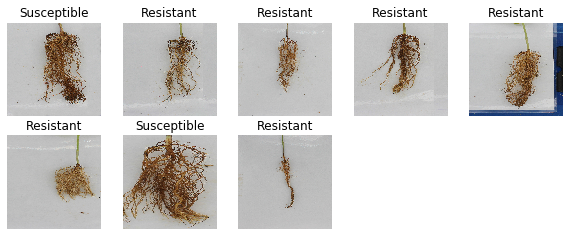

In [99]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [27]:
train_data_gen = ImageDataGenerator(rescale = 1/255.)
train_generator = train_data_gen.flow_from_directory(
    data_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = 128,
    class_mode='categorical'
)

Found 505 images belonging to 2 classes.


In [32]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [33]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/jupyter/.keras/datasets/SoyBean_Root_Images/susceptible/susceptible (22).jpg'
b'/home/jupyter/.keras/datasets/SoyBean_Root_Images/susceptible/susceptible (53).jpg'
b'/home/jupyter/.keras/datasets/SoyBean_Root_Images/resistant/cropped_resistant (12).jpg'
b'/home/jupyter/.keras/datasets/SoyBean_Root_Images/susceptible/cropped_susceptible (11).jpg'
b'/home/jupyter/.keras/datasets/SoyBean_Root_Images/resistant/Resistant30.jpg'


In [34]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [35]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [36]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [39]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [40]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  [False  True]


In [41]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [42]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [44]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

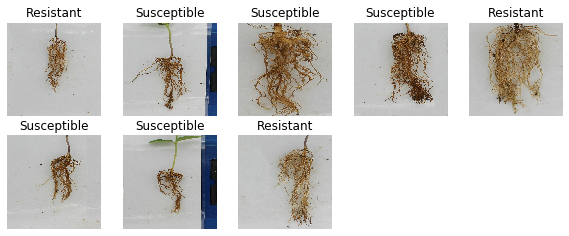

In [45]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [52]:
_URL = 'https://azibit-models-bucket-1.s3.amazonaws.com/SoyBean_Root_Images.zip'

path_to_zip = tf.keras.utils.get_file('SoyBean_Root_Images.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'SoyBean_Root_Images1')

427196416/427193760 [==============================] - 73s 0us/step


In [54]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    path_to_zip, split=list(splits),
    with_info=True, as_supervised=True)

ValueError: Parsing builder name string /home/jupyter/.keras/datasets/SoyBean_Root_Images.zip failed.
The builder name string must be of the following format:
  dataset_name[/config_name][:version][/kwargs]

  Where:

    * dataset_name and config_name are string following python variable naming.
    * version is of the form x.y.z where {x,y,z} can be any digit or *.
    * kwargs is a comma list separated of arguments and values to pass to
      builder.

  Examples:
    my_dataset
    my_dataset:1.2.*
    my_dataset/config1
    my_dataset/config1:1.*.*
    my_dataset/config1/arg1=val1,arg2=val2
    my_dataset/config1:1.2.3/right=True,foo=bar,rate=1.2
